In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('DCOILBRENTEU.csv')
df.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9524 entries, 0 to 9523
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          9524 non-null   object
 1   DCOILBRENTEU  9524 non-null   object
dtypes: object(2)
memory usage: 148.9+ KB


In [4]:
df.describe()

,DATE,DCOILBRENTEU
count,9524,9524
unique,9524,5243
top,1987-05-20,.
freq,1,259


In [5]:
df.tail()

,DATE,DCOILBRENTEU
9519,2023-11-14,84.2
9520,2023-11-15,82.4
9521,2023-11-16,77.73
9522,2023-11-17,81.22
9523,2023-11-20,83.25


In [6]:
df.columns=['Date','Value']
df.head()

,Date,Value
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [7]:
df['Value'] = df['Value'].replace('.', method='pad')
df['Value'] = df['Value'].replace('NaN', method='pad')

In [8]:
df['Value']=df['Value'].astype('float')

In [9]:
df['Date']=pd.to_datetime(df['Date'])

In [10]:
df.head()

,Date,Value
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [11]:
df.set_index('Date',inplace=True)

In [12]:
df.head()

,Value
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [13]:
df.describe()

,Value
count,9524.000000
mean,49.470877
std,33.018567
min,9.100000
25%,19.187500
50%,41.445000
75%,72.900000
max,143.950000


<Axes: xlabel='Date'>

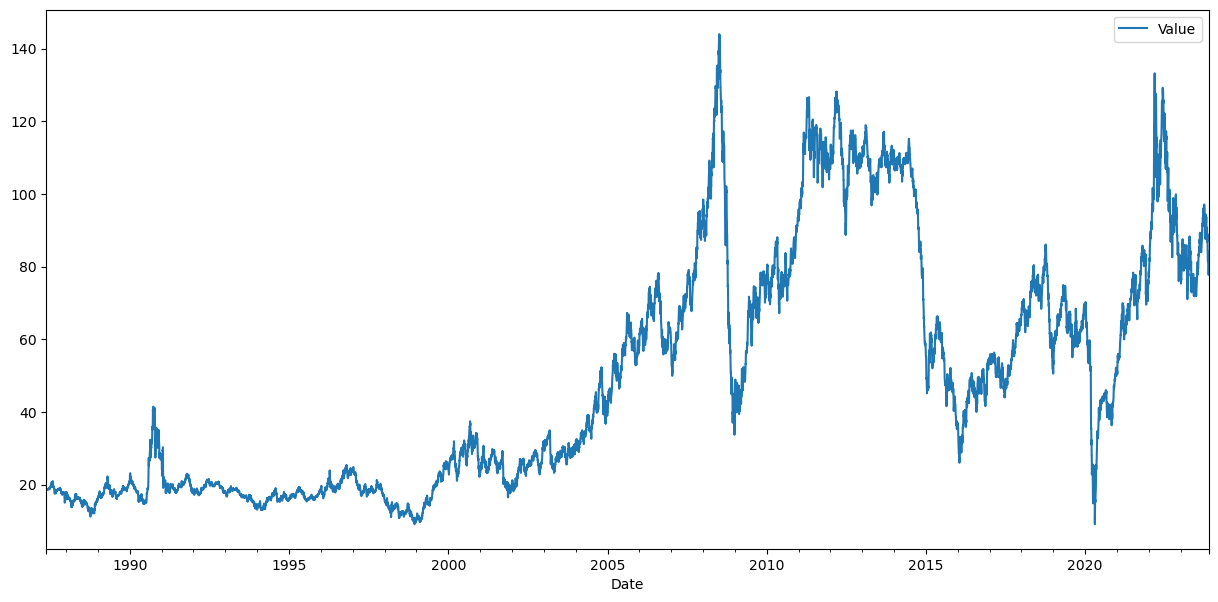

In [14]:
df.plot(figsize = (15,7))

In [15]:
df1 = df.reset_index()['Value']

In [16]:
df1

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
        ...  
9519    84.20
9520    82.40
9521    77.73
9522    81.22
9523    83.25
Name: Value, Length: 9524, dtype: float64

In [17]:
#Scaling data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
df1.shape

(9524, 1)

In [19]:
df1

array([[-0.93409553],
       [-0.9395473 ],
       [-0.93651854],
       ...,
       [ 0.85590047],
       [ 0.96160412],
       [ 1.02308791]])

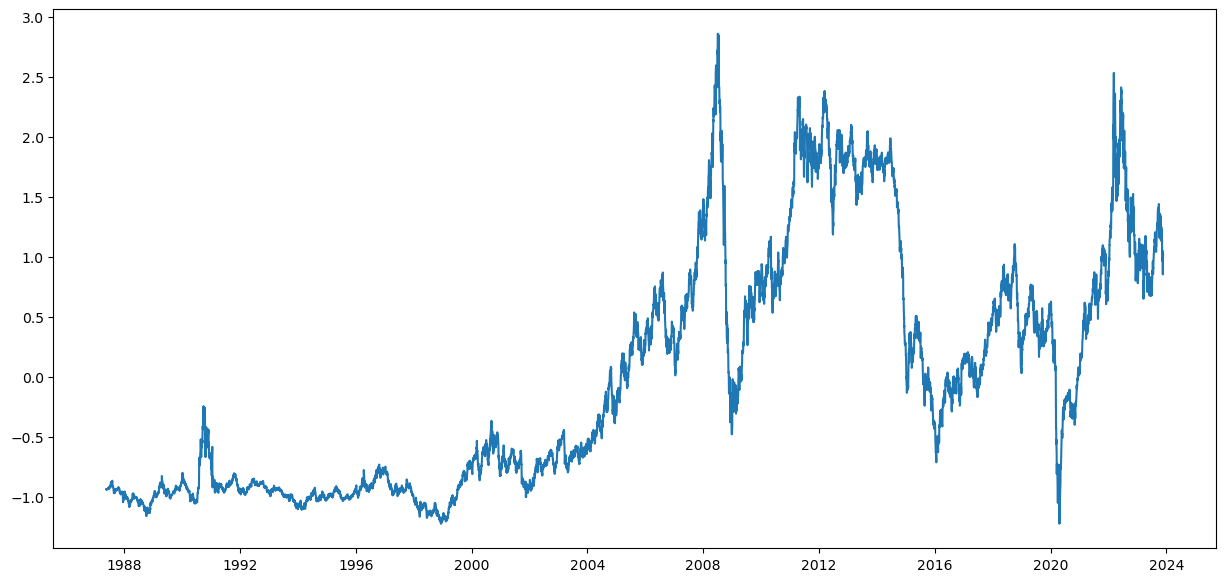

In [20]:
plt.figure(figsize=(15,7))
plt.plot(df.index,df1)

In [29]:
w = int(input('Enter window size: '))

Enter window size: 100


In [30]:
training_size = int(len(df1)*0.96)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size+w,:],df1[training_size:len(df1),:1]

In [31]:
train_data.shape, test_data.shape

((9243, 1), (381, 1))

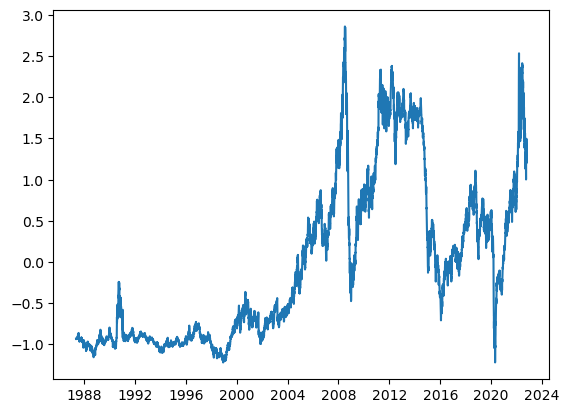

In [32]:
plt.plot(df.index[:training_size+100],train_data)

In [33]:
def create_dataset(dataset,time_step = 1):
    
    dataX, dataY = [],[]
    
    for i in range(len(dataset) - time_step):
        
        a = dataset[i:(i+time_step),0]
        
        dataX.append(a)
        
        dataY.append(dataset[i+time_step,0])
        
    return np.array(dataX), np.array(dataY)

In [34]:
time_step = w
#using 100 consecutive values predicting 101th value

X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [35]:
X_train.shape,X_test.shape

((9143, 100), (281, 100))

In [36]:
#making data 3d
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [37]:
X_train.shape,X_test.shape

((9143, 100, 1), (281, 100, 1))

In [38]:
!pip install tensorflow

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [40]:
 df.loc['2022-10-06']

Value    95.65
Name: 2022-10-06 00:00:00, dtype: float64

In [41]:
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 10,batch_size = 128, verbose =1)

Epoch 1/10

72/72 [==============================] - 29s 293ms/step - loss: 0.1509 - val_loss: 0.1003
Epoch 2/10
72/72 [==============================] - 19s 258ms/step - loss: 0.0605 - val_loss: 0.1040
Epoch 3/10
72/72 [==============================] - 20s 283ms/step - loss: 0.0564 - val_loss: 0.0883
Epoch 4/10
72/72 [==============================] - 20s 276ms/step - loss: 0.0511 - val_loss: 0.0842
Epoch 5/10
72/72 [==============================] - 18s 255ms/step - loss: 0.0490 - val_loss: 0.0791
Epoch 6/10
72/72 [==============================] - 20s 281ms/step - loss: 0.0458 - val_loss: 0.0732
Epoch 7/10
72/72 [==============================] - 21s 291ms/step - loss: 0.0445 - val_loss: 0.0710
Epoch 8/10
72/72 [==============================] - 21s 289ms/step - loss: 0.0440 - val_loss: 0.0681
Epoch 9/10
72/72 [==============================] - 20s 278ms/step - loss: 0.0409 - val_loss: 0.0655
Epoch 10/10
72/72 [==============================] - 20s 280ms/step - loss: 0.0388 - val_l

In [44]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 47ms/step


In [45]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [46]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

58.49001468543075

In [47]:
math.sqrt(mean_squared_error(y_test,test_predict))

83.4873996160603

In [48]:
train_predict.shape

(9143, 1)

In [49]:
test_predict.shape

(281, 1)

In [50]:
a = train_predict.reshape(train_predict.shape[0],)

In [51]:
b = test_predict.reshape(test_predict.shape[0],)

In [52]:
c = list(a)+list(b)

In [53]:
len(c)

9424

In [54]:
df

,Value
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2023-11-14,84.20
2023-11-15,82.40
2023-11-16,77.73


In [55]:
#diff of 100
t = []
for i in range(100):
    t.append(np.NAN)

In [56]:
d = t+c

In [57]:
len(d)

9524

In [58]:
df['Predicted Price'] = d

In [59]:
df

,Value,Predicted Price
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,NaN
1987-05-22,18.55,NaN
1987-05-25,18.60,NaN
1987-05-26,18.63,NaN
...,...,...
2023-11-14,84.20,82.754204
2023-11-15,82.40,83.200127
2023-11-16,77.73,83.487152


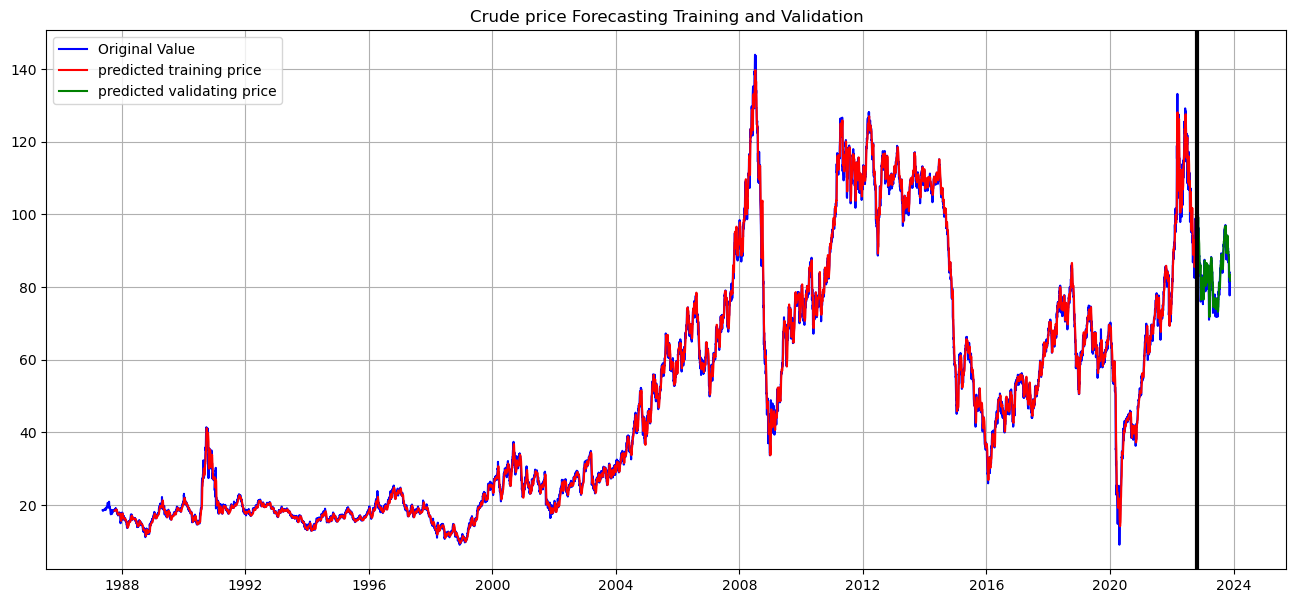

In [60]:
plt.figure(figsize = (16,7))
plt.grid(True)
plt.title('Crude price Forecasting Training and Validation')
plt.plot(df.index,df['Value'],label = 'Original Value',c = 'blue')
plt.plot(df[:train_predict.shape[0]+w].index,df['Predicted Price'][:train_predict.shape[0]+w],label = 'predicted training price',c = 'red')
plt.plot(df.index[train_predict.shape[0]+100:],df['Predicted Price'][train_predict.shape[0]+w:],label = 'predicted validating price',c = 'green')
plt.axvline(df.index[train_predict.shape[0]+w], color='black',lw=3)

plt.legend()

In [61]:
# forecasting in future

In [62]:
df

,Value,Predicted Price
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,NaN
1987-05-22,18.55,NaN
1987-05-25,18.60,NaN
1987-05-26,18.63,NaN
...,...,...
2023-11-14,84.20,82.754204
2023-11-15,82.40,83.200127
2023-11-16,77.73,83.487152


In [63]:
ddf = df[100:]

In [64]:
ddf

,Value,Predicted Price
Date,,
1987-10-07,18.58,18.472324
1987-10-08,18.63,18.481539
1987-10-09,18.60,18.487751
1987-10-12,18.55,18.489948
1987-10-13,18.55,18.485476
...,...,...
2023-11-14,84.20,82.754204
2023-11-15,82.40,83.200127
2023-11-16,77.73,83.487152


In [65]:
test_data.shape

(381, 1)

In [66]:
#for next one day price, last 100 days data is needed
x_input = test_data[-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [67]:
x_input

array([[0.8104691 , 0.82591576, 0.82531001, 0.88739955, 0.85892923,
        0.91072099, 0.93525393, 0.96433001, 0.92162452, 0.8580206 ,
        0.91072099, 0.90587498, 0.913144  , 0.95675811, 1.00128085,
        1.0294483 , 1.01491027, 1.05428412, 1.06064451, 1.08275445,
        1.08638896, 1.04610647, 1.1121334 , 1.14817562, 1.12061392,
        1.16695392, 1.20663065, 1.14999287, 1.16483379, 1.14878137,
        1.11485928, 1.06064451, 1.0833602 , 1.10395575, 1.08941771,
        1.0670049 , 1.04398634, 1.04792373, 1.08881196, 1.08881196,
        1.11758516, 1.12515706, 1.14544974, 1.22692333, 1.24024986,
        1.26538856, 1.28174385, 1.26266267, 1.2835611 , 1.28719561,
        1.33595862, 1.31960333, 1.3850245 , 1.39562515, 1.40774018,
        1.4125862 , 1.36564045, 1.33959313, 1.34837653, 1.34898228,
        1.36261169, 1.4425709 , 1.42863861, 1.4050143 , 1.26417705,
        1.36261169, 1.22238019, 1.17543444, 1.16271366, 1.26902307,
        1.24873039, 1.15423314, 1.17906895, 1.35

In [68]:
temp_input = list(x_input)


In [69]:
temp_input

[array([0.8104691 , 0.82591576, 0.82531001, 0.88739955, 0.85892923,
        0.91072099, 0.93525393, 0.96433001, 0.92162452, 0.8580206 ,
        0.91072099, 0.90587498, 0.913144  , 0.95675811, 1.00128085,
        1.0294483 , 1.01491027, 1.05428412, 1.06064451, 1.08275445,
        1.08638896, 1.04610647, 1.1121334 , 1.14817562, 1.12061392,
        1.16695392, 1.20663065, 1.14999287, 1.16483379, 1.14878137,
        1.11485928, 1.06064451, 1.0833602 , 1.10395575, 1.08941771,
        1.0670049 , 1.04398634, 1.04792373, 1.08881196, 1.08881196,
        1.11758516, 1.12515706, 1.14544974, 1.22692333, 1.24024986,
        1.26538856, 1.28174385, 1.26266267, 1.2835611 , 1.28719561,
        1.33595862, 1.31960333, 1.3850245 , 1.39562515, 1.40774018,
        1.4125862 , 1.36564045, 1.33959313, 1.34837653, 1.34898228,
        1.36261169, 1.4425709 , 1.42863861, 1.4050143 , 1.26417705,
        1.36261169, 1.22238019, 1.17543444, 1.16271366, 1.26902307,
        1.24873039, 1.15423314, 1.17906895, 1.35

In [70]:
temp_input = temp_input[0].tolist()

In [71]:
temp_input

[0.8104690981132208,
 0.8259157641308333,
 0.8253100125222996,
 0.8873995523970182,
 0.8589292267959278,
 0.9107209893255713,
 0.9352539294711915,
 0.964330006680816,
 0.9216245182791803,
 0.8580205993831269,
 0.9107209893255713,
 0.9058749764573002,
 0.9131439957597066,
 0.956758111574143,
 1.0012808548013803,
 1.0294483045982035,
 1.0149102659933917,
 1.054284120548091,
 1.0606445124376962,
 1.0827544461491816,
 1.0863889558003847,
 1.0461064738328845,
 1.1121333991630729,
 1.1481756198708362,
 1.1206139216825466,
 1.1669539197353853,
 1.206630650094352,
 1.1499928746964376,
 1.1648337891055172,
 1.1487813714793702,
 1.114859281401475,
 1.0606445124376962,
 1.0833601977577152,
 1.103955752447866,
 1.0894177138430539,
 1.0670049043273018,
 1.0439863432030159,
 1.0479237286584857,
 1.08881196223452,
 1.08881196223452,
 1.1175851636398775,
 1.1251570587465505,
 1.1454497376324342,
 1.2269233289802355,
 1.24024986436798,
 1.2653885561221343,
 1.2817438495525482,
 1.2626626738837319,
 1.2

In [72]:
#demonstrate prediction for next 30 days

lst_output = []
n_steps = 100
i = 0
while i<30:
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print('{} day input {}'.format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps,1))
        
        yhat = model.predict(x_input,verbose = 1)
        print('{} day output {}'.format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input,verbose = 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
        
print(lst_output)

[0.9758223]
101
1 day input [0.82591576 0.82531001 0.88739955 0.85892923 0.91072099 0.93525393
 0.96433001 0.92162452 0.8580206  0.91072099 0.90587498 0.913144
 0.95675811 1.00128085 1.0294483  1.01491027 1.05428412 1.06064451
 1.08275445 1.08638896 1.04610647 1.1121334  1.14817562 1.12061392
 1.16695392 1.20663065 1.14999287 1.16483379 1.14878137 1.11485928
 1.06064451 1.0833602  1.10395575 1.08941771 1.0670049  1.04398634
 1.04792373 1.08881196 1.08881196 1.11758516 1.12515706 1.14544974
 1.22692333 1.24024986 1.26538856 1.28174385 1.26266267 1.2835611
 1.28719561 1.33595862 1.31960333 1.3850245  1.39562515 1.40774018
 1.4125862  1.36564045 1.33959313 1.34837653 1.34898228 1.36261169
 1.4425709  1.42863861 1.4050143  1.26417705 1.36261169 1.22238019
 1.17543444 1.16271366 1.26902307 1.24873039 1.15423314 1.17906895
 1.3586743  1.25751379 1.30385378 1.28780137 1.32202633 1.34019888
 1.28446973 1.16695392 1.23176934 1.18058333 1.24963901 1.24963901
 1.13121457 1.13424333 1.19784725 1.1

1/1 [==============================] - 0s 69ms/step
7 day output [[1.0256321]]
8 day input [0.92162452 0.8580206  0.91072099 0.90587498 0.913144   0.95675811
 1.00128085 1.0294483  1.01491027 1.05428412 1.06064451 1.08275445
 1.08638896 1.04610647 1.1121334  1.14817562 1.12061392 1.16695392
 1.20663065 1.14999287 1.16483379 1.14878137 1.11485928 1.06064451
 1.0833602  1.10395575 1.08941771 1.0670049  1.04398634 1.04792373
 1.08881196 1.08881196 1.11758516 1.12515706 1.14544974 1.22692333
 1.24024986 1.26538856 1.28174385 1.26266267 1.2835611  1.28719561
 1.33595862 1.31960333 1.3850245  1.39562515 1.40774018 1.4125862
 1.36564045 1.33959313 1.34837653 1.34898228 1.36261169 1.4425709
 1.42863861 1.4050143  1.26417705 1.36261169 1.22238019 1.17543444
 1.16271366 1.26902307 1.24873039 1.15423314 1.17906895 1.3586743
 1.25751379 1.30385378 1.28780137 1.32202633 1.34019888 1.28446973
 1.16695392 1.23176934 1.18058333 1.24963901 1.24963901 1.13121457
 1.13424333 1.19784725 1.15332451 1.14605

1/1 [==============================] - 0s 56ms/step
14 day output [[1.0749396]]
15 day input [1.0294483  1.01491027 1.05428412 1.06064451 1.08275445 1.08638896
 1.04610647 1.1121334  1.14817562 1.12061392 1.16695392 1.20663065
 1.14999287 1.16483379 1.14878137 1.11485928 1.06064451 1.0833602
 1.10395575 1.08941771 1.0670049  1.04398634 1.04792373 1.08881196
 1.08881196 1.11758516 1.12515706 1.14544974 1.22692333 1.24024986
 1.26538856 1.28174385 1.26266267 1.2835611  1.28719561 1.33595862
 1.31960333 1.3850245  1.39562515 1.40774018 1.4125862  1.36564045
 1.33959313 1.34837653 1.34898228 1.36261169 1.4425709  1.42863861
 1.4050143  1.26417705 1.36261169 1.22238019 1.17543444 1.16271366
 1.26902307 1.24873039 1.15423314 1.17906895 1.3586743  1.25751379
 1.30385378 1.28780137 1.32202633 1.34019888 1.28446973 1.16695392
 1.23176934 1.18058333 1.24963901 1.24963901 1.13121457 1.13424333
 1.19784725 1.15332451 1.14605549 1.02853968 0.96887314 0.97735367
 1.03550582 1.04852948 1.05186111 0.9

1/1 [==============================] - 0s 62ms/step
21 day output [[1.1287299]]
22 day input [1.1121334  1.14817562 1.12061392 1.16695392 1.20663065 1.14999287
 1.16483379 1.14878137 1.11485928 1.06064451 1.0833602  1.10395575
 1.08941771 1.0670049  1.04398634 1.04792373 1.08881196 1.08881196
 1.11758516 1.12515706 1.14544974 1.22692333 1.24024986 1.26538856
 1.28174385 1.26266267 1.2835611  1.28719561 1.33595862 1.31960333
 1.3850245  1.39562515 1.40774018 1.4125862  1.36564045 1.33959313
 1.34837653 1.34898228 1.36261169 1.4425709  1.42863861 1.4050143
 1.26417705 1.36261169 1.22238019 1.17543444 1.16271366 1.26902307
 1.24873039 1.15423314 1.17906895 1.3586743  1.25751379 1.30385378
 1.28780137 1.32202633 1.34019888 1.28446973 1.16695392 1.23176934
 1.18058333 1.24963901 1.24963901 1.13121457 1.13424333 1.19784725
 1.15332451 1.14605549 1.02853968 0.96887314 0.97735367 1.03550582
 1.04852948 1.05186111 0.99734347 0.85590047 0.96160412 1.02308791
 0.97582233 0.98027849 0.9872542  0.9

1/1 [==============================] - 0s 64ms/step
28 day output [[1.1936138]]
29 day input [1.14878137 1.11485928 1.06064451 1.0833602  1.10395575 1.08941771
 1.0670049  1.04398634 1.04792373 1.08881196 1.08881196 1.11758516
 1.12515706 1.14544974 1.22692333 1.24024986 1.26538856 1.28174385
 1.26266267 1.2835611  1.28719561 1.33595862 1.31960333 1.3850245
 1.39562515 1.40774018 1.4125862  1.36564045 1.33959313 1.34837653
 1.34898228 1.36261169 1.4425709  1.42863861 1.4050143  1.26417705
 1.36261169 1.22238019 1.17543444 1.16271366 1.26902307 1.24873039
 1.15423314 1.17906895 1.3586743  1.25751379 1.30385378 1.28780137
 1.32202633 1.34019888 1.28446973 1.16695392 1.23176934 1.18058333
 1.24963901 1.24963901 1.13121457 1.13424333 1.19784725 1.15332451
 1.14605549 1.02853968 0.96887314 0.97735367 1.03550582 1.04852948
 1.05186111 0.99734347 0.85590047 0.96160412 1.02308791 0.97582233
 0.98027849 0.9872542  0.99492037 1.00269866 1.0104413  1.01809859
 1.02563214 1.03301156 1.04022586 1.0

In [73]:
lst_output

[[0.9758223295211792],
 [0.980278491973877],
 [0.9872542023658752],
 [0.9949203729629517],
 [1.0026986598968506],
 [1.0104413032531738],
 [1.0180985927581787],
 [1.0256321430206299],
 [1.033011555671692],
 [1.040225863456726],
 [1.0472890138626099],
 [1.054236888885498],
 [1.0611211061477661],
 [1.0680018663406372],
 [1.0749396085739136],
 [1.08199143409729],
 [1.0892066955566406],
 [1.0966242551803589],
 [1.1042726039886475],
 [1.112169623374939],
 [1.1203222274780273],
 [1.1287299394607544],
 [1.1373846530914307],
 [1.1462733745574951],
 [1.1553796529769897],
 [1.164684772491455],
 [1.1741706132888794],
 [1.1838189363479614],
 [1.1936137676239014],
 [1.2035406827926636]]

In [74]:
forecast = scaler.inverse_transform(lst_output)

In [75]:
forecast.shape

(30, 1)

In [76]:
forecast = forecast.reshape(30,)

In [77]:
ddf

,Value,Predicted Price
Date,,
1987-10-07,18.58,18.472324
1987-10-08,18.63,18.481539
1987-10-09,18.60,18.487751
1987-10-12,18.55,18.489948
1987-10-13,18.55,18.485476
...,...,...
2023-11-14,84.20,82.754204
2023-11-15,82.40,83.200127
2023-11-16,77.73,83.487152


In [78]:
t_fut = pd.date_range('2023-11-21 00:00+00:00',periods=30)

In [79]:
t_fut

DatetimeIndex(['2023-11-21 00:00:00+00:00', '2023-11-22 00:00:00+00:00',
               '2023-11-23 00:00:00+00:00', '2023-11-24 00:00:00+00:00',
               '2023-11-25 00:00:00+00:00', '2023-11-26 00:00:00+00:00',
               '2023-11-27 00:00:00+00:00', '2023-11-28 00:00:00+00:00',
               '2023-11-29 00:00:00+00:00', '2023-11-30 00:00:00+00:00',
               '2023-12-01 00:00:00+00:00', '2023-12-02 00:00:00+00:00',
               '2023-12-03 00:00:00+00:00', '2023-12-04 00:00:00+00:00',
               '2023-12-05 00:00:00+00:00', '2023-12-06 00:00:00+00:00',
               '2023-12-07 00:00:00+00:00', '2023-12-08 00:00:00+00:00',
               '2023-12-09 00:00:00+00:00', '2023-12-10 00:00:00+00:00',
               '2023-12-11 00:00:00+00:00', '2023-12-12 00:00:00+00:00',
               '2023-12-13 00:00:00+00:00', '2023-12-14 00:00:00+00:00',
               '2023-12-15 00:00:00+00:00', '2023-12-16 00:00:00+00:00',
               '2023-12-17 00:00:00+00:00', '2023-1

In [80]:
dffor = pd.DataFrame({'Forecast Price':forecast},index = t_fut)

In [81]:
dffor.loc['2023-12-29']

Forecast Price    83.815841
Name: 2023-11-30 00:00:00+00:00, dtype: float64

In [82]:
dffor

,Forecast Price
2023-11-21 00:00:00+00:00,81.689440
2023-11-22 00:00:00+00:00,81.836568
2023-11-23 00:00:00+00:00,82.066884
2023-11-24 00:00:00+00:00,82.319997
2023-11-25 00:00:00+00:00,82.576811
2023-11-26 00:00:00+00:00,82.832449
2023-11-27 00:00:00+00:00,83.085268
2023-11-28 00:00:00+00:00,83.334002
2023-11-29 00:00:00+00:00,83.577647
2023-11-30 00:00:00+00:00,83.815841


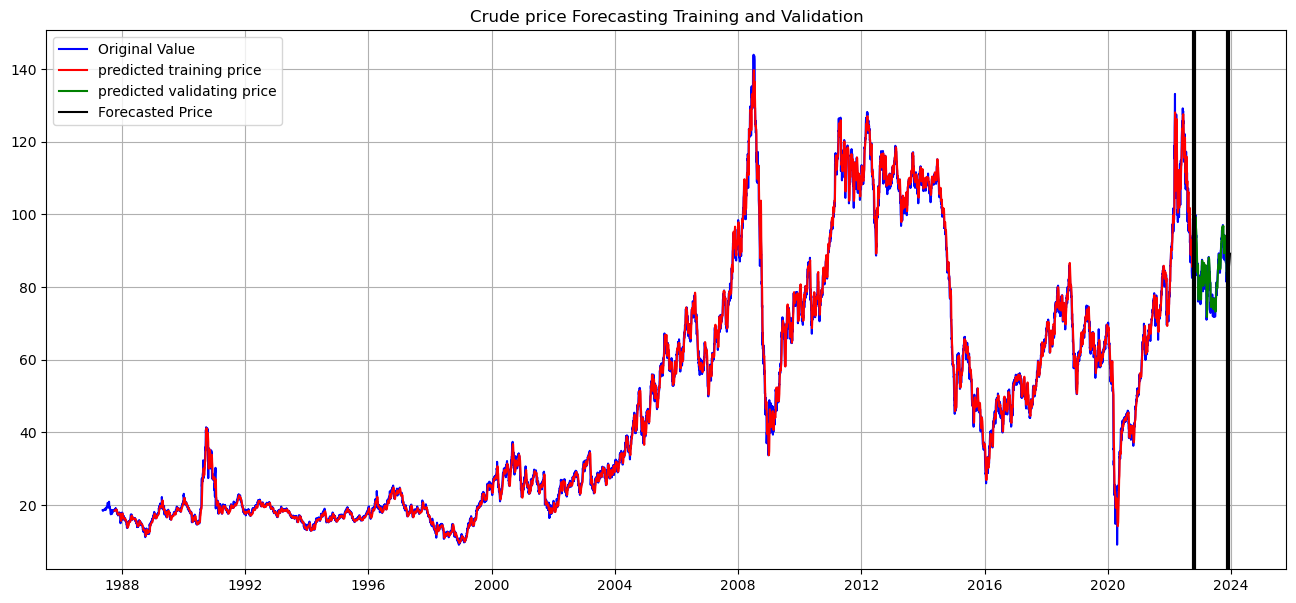

In [83]:
plt.figure(figsize = (16,7))
plt.grid(True)
plt.title('Crude price Forecasting Training and Validation')
plt.plot(df.index,df['Value'],label = "Original Value",c = 'blue')
plt.plot(df[:train_predict.shape[0]+w].index,df['Predicted Price'][:train_predict.shape[0]+w],label = 'predicted training price',c = 'red')
plt.plot(df.index[train_predict.shape[0]+100:],df['Predicted Price'][train_predict.shape[0]+w:],label = 'predicted validating price',c = 'green')

plt.plot(dffor.index,dffor['Forecast Price'],label = 'Forecasted Price',c='black')

plt.axvline(df.index[train_predict.shape[0]+w], color='black',lw=3)
plt.axvline(dffor.index[0],color='black',lw=3)

plt.legend()

In [84]:
dffor.loc['2023-12-29']

Forecast Price    84.732917
Name: 2023-12-04 00:00:00+00:00, dtype: float64